In [1]:
% load_ext autoreload
% autoreload 2

In [2]:
import sys; sys.path += ['..', '../src']

In [3]:
import os
from itertools import islice

from src.vocab import Vocab

DATA_PATH = '../data/generated'
min_len = 5
max_len = 100

classics_path = os.path.join(DATA_PATH, 'classics.tok.bpe')
news_path = os.path.join(DATA_PATH, 'news.ru.tok.bpe')

classics = open(classics_path, 'r', encoding='utf-8').read().splitlines()
news = open(news_path, 'r', encoding='utf-8').read().splitlines()
# TODO: replace with full file when dev is done
# with open(classics_path, encoding='utf-8') as classics_file, open(news_path, encoding='utf-8') as news_file:
#     classics = list(islice(classics_file, 10**4))
#     news = list(islice(news_file, 10**4))

classics = [s for s in classics if min_len < len(s.split()) < (max_len - 2)]
news = [s for s in news if min_len < len(s.split()) < (max_len - 2)]

vocab = Vocab.from_sequences(classics + news)
vocab.token2id['__DROP__'] = len(vocab)
vocab.tokens.append('__DROP__')

In [4]:
classics, classics_val = classics[:-1000], classics[-1000:]
news, news_val = news[:-1000], news[-1000:]

In [5]:
%matplotlib inline

import os
import torch
import torch.nn as nn
from torch.optim import Adam

from src.models import Transformer
from src.dataloaders import WordRecoveryDataloader
from src.vocab import constants
from src.trainers import WordRecoveryTrainer

log_file_path = '../logs/word_recovery.log'

# Let's clean log file
if os.path.exists(log_file_path): os.remove(log_file_path)

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)

transformer = Transformer(len(vocab), len(vocab), max_len)
optimizer = Adam(transformer.get_trainable_parameters(), lr=1e-4)
criterion = reconstruction_criterion(len(vocab))

config = {
    'max_num_epochs': 100,
    'plot_every': 50,
    'validate_every': 200,
    'mixing_scheme': (0.5, 0.2, 30000),
    'log_file': log_file_path,
    'max_len': 20
}

trainer = WordRecoveryTrainer(transformer, optimizer, criterion, vocab, config)
training_data = WordRecoveryDataloader(classics, news, vocab, trainer.mixing_coef, batch_size=64)
val_data = WordRecoveryDataloader(classics_val[:256], news_val[:256], vocab, batch_size=64)

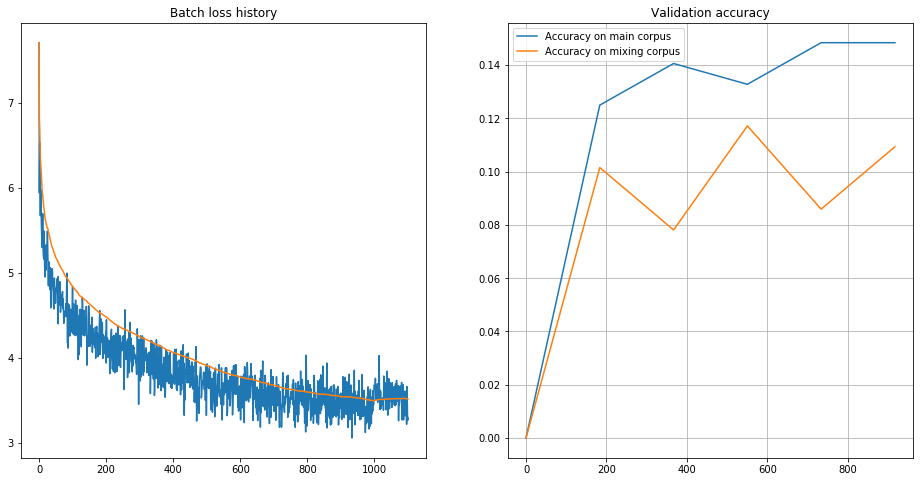

  4%|▍         | 1142/29647 [07:26<3:05:49,  2.56it/s]

In [ ]:
trainer.run_training(training_data, val_data)

Ok, let's now try to translate some news.
For this we should generate from a sentence (of `n` words) `n` sentences with `__DROP__` word in place of each word.
Named entities, I suppose, should be transferred as is. But this will be the next iteration.

In [ ]:
news_test = news_val[-10:]